Probability of Default (PD) Prediction Model with MLflow Tracking and Registry

In [2]:
!pip install pandas scikit-learn matplotlib seaborn mlflow


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


In [4]:
X, y = make_classification(
    n_samples=1000, n_features=10, n_informative=6, n_redundant=2,
    weights=[0.7, 0.3], flip_y=0.01, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [5]:
#model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_probs)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)


Accuracy: 0.89
ROC AUC: 0.9407749690435203


2025/04/06 16:56:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'pd_model_v1' already exists. Creating a new version of this model...
Created version '3' of model 'pd_model_v1'.


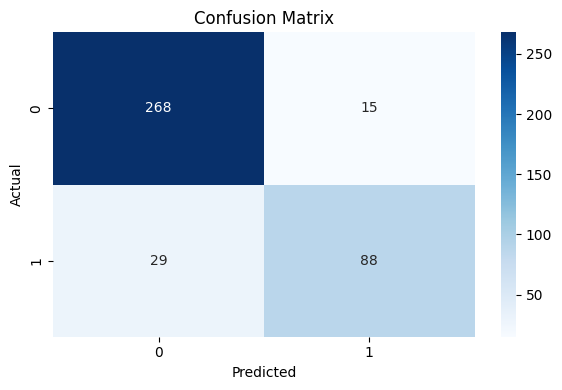

In [7]:
mlflow.set_experiment("PD_Classification_Experiment")

with mlflow.start_run():
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 7)
    
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)

    cm = confusion_matrix(y_test, y_preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("conf_matrix.png")
    mlflow.log_artifact("conf_matrix.png")

    mlflow.sklearn.log_model(model, "model", registered_model_name="pd_model_v1")


In [7]:
loaded_model = mlflow.sklearn.load_model("models:/pd_model_v1/latest")
X_new = np.random.rand(3, 10)
predicted_probs = loaded_model.predict_proba(X_new)[:, 1]

print("Predicted Default Probabilities:", predicted_probs)


Predicted Default Probabilities: [0.39088214 0.62193869 0.32424404]


In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
    name="pd_model_v1",
    version=1,  # version from UI
    stage="Production"
)


C:\Users\Home\AppData\Local\Temp\ipykernel_26824\1900257192.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1743915640361, current_stage='Production', description=None, last_updated_timestamp=1743916009212, name='pd_model_v1', run_id='009e2e4a78594b53b81da6a8b2f171ff', run_link=None, source='file:///e:/mlflowMiniProject/mlruns/498475943045699718/009e2e4a78594b53b81da6a8b2f171ff/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

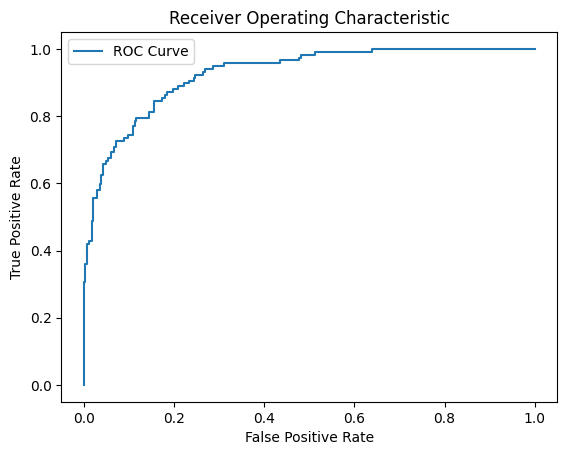

In [9]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png")


In [10]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=params, cv=3)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 7, 'n_estimators': 50}
